In [780]:
import pandas
import matplotlib.pyplot as plt
import numpy


url_confirmed = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
raw_df_confirmed = pandas.read_csv(url_confirmed)
df_c = raw_df_confirmed.copy()
del df_c['Long']
del df_c['Lat']
df_c = df_c.set_index(['Country/Region','Province/State'])\
           .transpose() # transpose to get dates as rows
# make a proper datetime index
df_c = df_c.set_index(pandas.to_datetime(df_c.index))

In [781]:
[(a,b) for a, b in df_c.columns if 'orea' in a]

[('Korea, South', nan)]

In [792]:
country, province = 'Germany', float('Nan')

In [793]:
de = df_c[country, province]
de = de[de.index[(de > 50)][0]:]
deltas = (de - de.shift(1)).dropna()

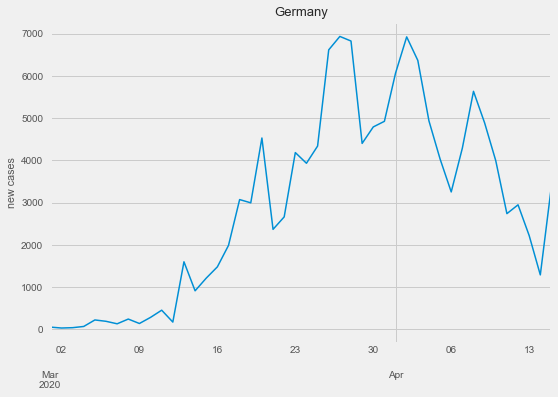

In [794]:
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 9
plt.rcParams['lines.linewidth'] = 1.5
plt.title(country)
plt.ylabel("new cases")
deltas.plot.line()

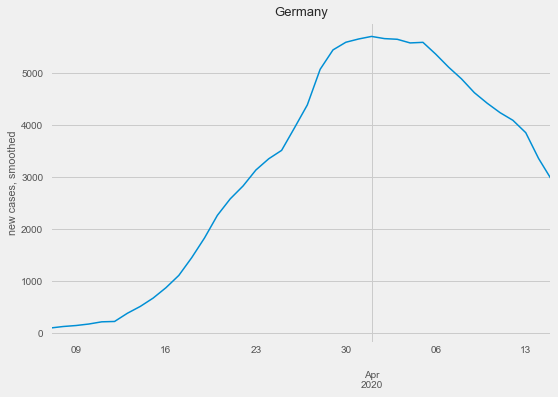

In [798]:
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 9
plt.rcParams['lines.linewidth'] = 1.5
plt.title(country)
plt.ylabel("new cases, smoothed")
k = deltas.rolling(7, win_type='gaussian').mean(std=3).dropna().round()
k.plot.line()

In [799]:
tau = 1

In [765]:
import scipy

In [766]:
r_range = numpy.linspace(0, 10, 500)

In [800]:
Tc = 5.2
gamma = 1/Tc
lambdas = numpy.outer(k[:-1],  numpy.exp(tau*gamma*(r_range - 1)))

In [768]:
import scipy.stats

In [801]:
L = scipy.stats.poisson.pmf(k[1:], lambdas.T)

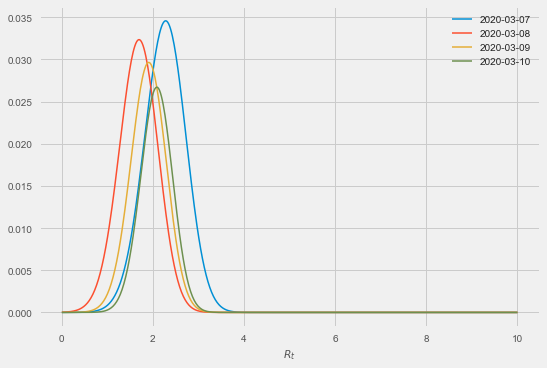

In [802]:
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 9
plt.rcParams['lines.linewidth'] = 1.5
for i in range(4):
    plt.plot(r_range, L[:,i], label=k.index[i].date())
plt.xlabel("$R_t$")
plt.legend()

In [812]:
P  = L.copy()
#P[:,0] /= P[0].sum()
#for i in range(1, P.shape[1]):
#    P[:,i] *= P[:,i-1]
#    P[:,i] /= P[:,i].sum()
W = 2
for i in range(L.shape[1]):
    P[:,i] = L[:,i] / L[:,i].sum()
    for j in range(1, min(W, i)):
        P[:,i] *= L[:,i-j]
        P[:,i] /= P[:,i].sum()

In [813]:
lower = [r_range[numpy.argwhere(P[:,i].cumsum() >= 0.025)[0]][0] for i in range(len(k) - 1)]
middle = [r_range[numpy.argwhere(P[:,i].cumsum() >= 0.5)[0]][0] for i in range(len(k) - 1)]
upper = [r_range[numpy.argwhere(P[:,i].cumsum() >= 0.975)[0]][0] for i in range(len(k) - 1)]

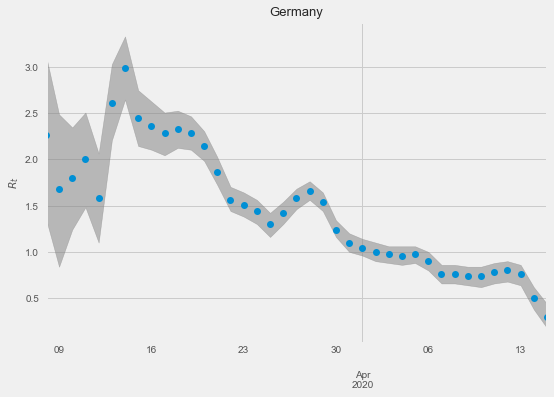

In [814]:
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 9
plt.rcParams['lines.linewidth'] = 1.5
plt.ylabel('$R_t$')
pandas.Series(middle, index=k.index[1:]).plot.line(lw=0, marker="o")
plt.fill_between(k.index[1:], lower, upper, color='grey', alpha=0.5)
plt.title(country)
plt.savefig('R_tNorway.png', dpi=300)

In [830]:
country = 'Spain'
def estimate_R(country):
    de = df_c[country, float('nan')]
    de = de[de.index[(de > 30)][0]:]
    deltas = (de - de.shift(1)).dropna()
    k = deltas.rolling(4, win_type='gaussian').mean(std=3).dropna().round()
    tau = 1
    r_range = numpy.linspace(0, 10, 500)
    Tc = 5.2
    gamma = 1/Tc
    lambdas = numpy.outer(k[:-1],  numpy.exp(tau*gamma*(r_range - 1)))
    L = scipy.stats.poisson.pmf(k[1:], lambdas.T)
    P  = L.copy()
    W = 7
    for i in range(L.shape[1]):
        P[:,i] = L[:,i] / L[:,i].sum()
        for j in range(1, min(W, i)):
            P[:,i] *= L[:,i-j]
            P[:,i] /= P[:,i].sum()
    lower = [r_range[numpy.argwhere(P[:,i].cumsum() >= 0.025)[0]][0] for i in range(len(k) - 1)]
    middle = [r_range[numpy.argwhere(P[:,i].cumsum() >= 0.5)[0]][0] for i in range(len(k) - 1)]
    upper = [r_range[numpy.argwhere(P[:,i].cumsum() >= 0.975)[0]][0] for i in range(len(k) - 1)]
    return pandas.DataFrame({'median': middle, 'lower': lower, 'upper': upper}, index=k.index[1:])

In [831]:
def plot_country(country_to_estimate):
    estimates = estimate_R(country_to_estimate)
    estimates['median'].plot.line(marker='o', lw=0)
    plt.fill_between(estimates.index, estimates['lower'], estimates['upper'], alpha=0.6, color='grey')
    plt.title(country_to_estimate)

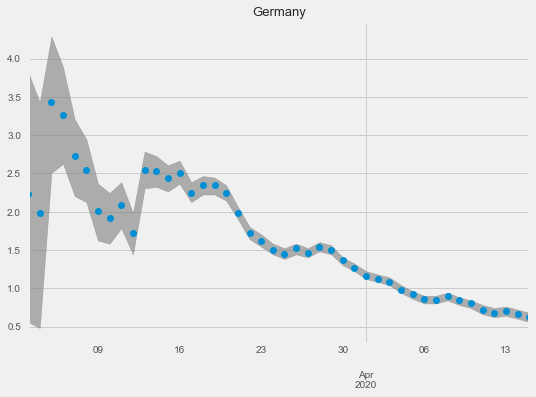

In [832]:
plot_country('Germany')

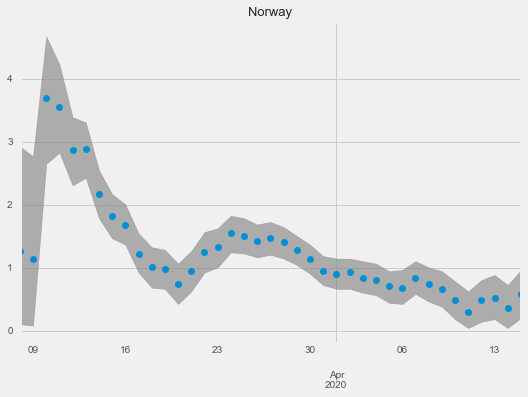

In [833]:
plot_country("Norway")

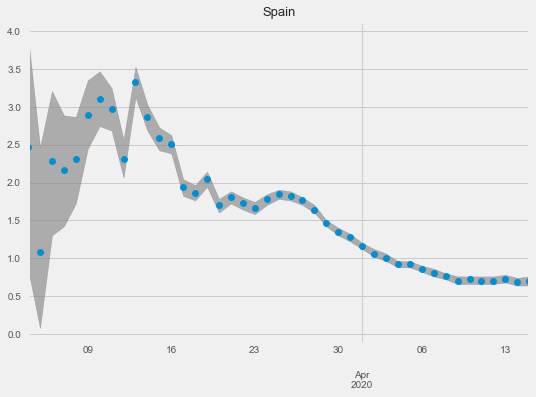

In [834]:
plot_country('Spain')

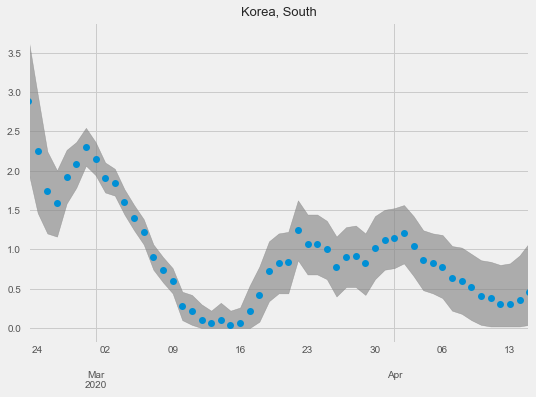

In [835]:
plot_country('Korea, South')